In [2]:
from abc import ABC, abstractmethod
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from numpy.polynomial.hermite import hermgauss
from itertools import product
from scipy.interpolate import interp2d


In [3]:
with open('..//data//fertility.pkl', 'rb' ) as f:
    fertility_data = pickle.load(f)
    
with open('..//data//men_wage_path.pkl', 'rb' ) as f:
    men_wage_path_data = pickle.load(f)
    
with open('..//data//men_hours_empirical', 'rb') as f:
    men_hours_data = pickle.load(f)

In [4]:
men_salary_path = np.array(men_hours_data * men_wage_path_data * 46)

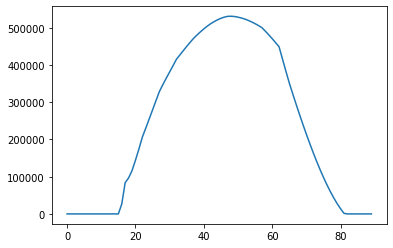

In [5]:
plt.plot(men_salary_path)

In [6]:
class InterfaceEnvironment(ABC):
    
    @abstractmethod
    def __init__(self):
        pass
    
    @property
    @abstractmethod
    def states(self):
        """The representation of the state space"""
        pass
    
    
    @abstractmethod
    def step(self, action):
        """Takes a step. Uses action for the step
        
        returns
        =======
        
        
        """
        pass
    
    @abstractmethod
    def reset(self):
        """resets environment. Defaults back to starting period. 
        reset method also can take a state (used for solving the model)"""
        pass
    
    

In [45]:
class EnvironmentModel1(InterfaceEnvironment):
    
    """
    Ordering of items
    states: Q, M, K, W
    shocks: epsilon, rho, psi
    """
    
    DEFAULT_Q = 18
    DEFAULT_G = 2.0
    DEFAULT_K = 0
    DEFAULT_Z = 0.0
    
    def __init__(self, sigma_epsilon, S_min, eta_G, eta_G_sq, alpha, delta, beta_K, beta_L):
        
        #parameters
        self.sigma_epsilon = sigma_epsilon
        self.S_min = S_min
        self.eta_G = eta_G
        self.eta_G_sq = eta_G_sq
        self.alpha = alpha
        self.delta = delta
        
        # The parameters that need to be tuned!
        self.beta_K = beta_K
        self.beta_L = beta_L

        #states
        self.Q = self.DEFAULT_Q
        self.G = self.DEFAULT_G
        self.K = self.DEFAULT_K
        self.Z = self.DEFAULT_Z
        
    def __repr__(self):
        return f"(Q: {self.Q}, G: {self.G}, K: {self.K}, Z: {self.Z})"
    
    @property
    def states(self):
        return self.Q, self.G, self.K, self.Z
    

    
    def reset(self, states=None, parameters=None):
        """Expect states given as: (Q, G, K, Z) """
        if states is not None:
            Q, G, K, Z = states[0], states[1], states[2], states[3]
            self.Q = Q
            self.G = G
            self.K = K
            self.Z = Z
        else:
            self.Q = self.DEFAULT_Q
            self.G = self.DEFAULT_G
            self.K = self.DEFAULT_K
            self.Z = self.DEFAULT_Z
            
        if parameters is not None:
            for key, val in parameters.items():
                setattr(self, key, val)
        
    def step(self, action, shocks=None, parameters=None):
        """
        shocks:
            (epsilon, psi) <- that order
        """
        if shocks is None:
             shocks = self.draw_shocks()
        epsilon, psi = shocks

        if parameters is not None:
            for key, val in parameters.items():
                setattr(self, key, val)
        # remember action: hours (H)
    
        ### transition
        self.calc_Q()
        self.calc_G(action)
        self.calc_K(psi)
        self.calc_Z(epsilon)
        
        ### model dynamic
        L = self.calc_L(action)
        
        # wage/salary process
        log_S_tilde = self.calc_log_S_tilde()
        S = self.calc_S(log_S_tilde)
        W = self.calc_W(S, action)

        # husband income
        M = self.calc_M()
        
        # household income
        Y = self.calc_Y(W, M)
        
        utility = self.calc_U(L, Y)
        

        # this might be changed
        done = self.calc_stops()
        
        _info = f'Y: {Y}, L: {L}, W: {W}' 
        if done is True:
            return self.states, utility, True, _info 
        
        return self.states, utility, False, _info

    
    #model dynamic
    def calc_log_S_tilde(self):
        return self.alpha + self.eta_G * self.G + self.eta_G_sq * self.G**2
    
    def calc_U(self, L, Y):
        u = self.beta_K * np.log(self.K + 1) + self.beta_L * np.log(L + 1) + np.log(Y + 1)
        if np.isnan(u):
            raise Exception(f"K: {self.K}, L: {L}, Y: {Y}")
        return u
    
    def calc_W(self, S, H):
        return S * H
    
    def calc_M(self):
        # use data (non parametric)
        return men_salary_path[self.Q]
    
    def calc_Y(self, W, M ):
        return W + M
    
    def calc_L(self, hours):
        return 46 * (7 * 24 - hours)
    
    def calc_stops(self):
        # stops the model (returns done flag)
        if self.Q > 60:
            return True
        return False
    
    def calc_K(self, psi):
        if self.K < 5:
            self.K = self.K + psi
    
    def calc_S(self, log_S_tilde):
        _S = np.exp(log_S_tilde)+ self.Z
        return max(self.S_min, _S)
                           
    def calc_Q(self):
        self.Q = self.Q + 1
    
    def calc_G(self, H):
        self.G = self.G * (1 - self.delta) + H/37
        
    def calc_Z(self, epsilon):
        self.Z = self.Z + epsilon
    
    # def shocks
    def draw_shocks(self):
        return (self.draw_epsilon(), self.draw_psi())
        
    def draw_epsilon(self):
        return np.random.normal(0, self.sigma_epsilon)
    
    def get_p_psi(self):
        return fertility_data[self.Q]
    
    def draw_psi(self):
        p_psi = self.get_p_psi()
        return np.random.binomial(1, p_psi)


In [29]:
parameters = {
    'beta_K' : 1,
    'beta_L' : 1,
    'sigma_epsilon' : 0.1, 
    'S_min': 120.0,
    'alpha': 4.609,
    'eta_G': 0.164,
    'eta_G_sq' : 0.015,
    'delta': 0.209,
    'sigma_epsilon': 15.11
}
env = EnvironmentModel1(**parameters)

In [30]:
def random_action():
    actions = [0, 15, 25, 37, 45]
    return np.random.choice(actions)

In [46]:
#env = EnvironmentModel1(**parameters)

done = False
env.reset()
while not done:
    action = random_action()
    _states, reward, done, _info = env.step(action, parameters={'beta_L':1000})
    print('utility', reward)
    print(_info)
    print(env, '\n')
    

utility 8964.397589013639
Y: 116170.39314917395, L: 7728, W: 0.0
(Q: 19, G: 1.582, K: 0, Z: -19.55652419393198) 

utility 8803.535879277317
Y: 146948.19463873943, L: 6578, W: 3000.0
(Q: 20, G: 1.9270376756756757, K: 0, Z: -45.35492203318354) 

utility 8871.297705648813
Y: 175660.13357448313, L: 7038, W: 1800.0
(Q: 21, G: 1.929692206864865, K: 0, Z: -68.12335600700253) 

utility 8871.464130933713
Y: 207468.02400000003, L: 7038, W: 1800.0
(Q: 22, G: 1.9317919410355138, K: 0, Z: -77.63616421023099) 

utility 8965.08032874766
Y: 229936.230729697, L: 7728, W: 0.0
(Q: 23, G: 1.5280474253590914, K: 0, Z: -77.8193542923561) 

utility 8965.181811195553
Y: 254495.93932716886, L: 7728, W: 0.0
(Q: 24, G: 1.2086855134590413, K: 0, Z: -99.9131945679137) 

utility 8871.76759234311
Y: 281023.9501597922, L: 7038, W: 1800.0
(Q: 25, G: 1.3614756465515072, K: 0, Z: -80.10475744788647) 

utility 8716.643929818913
Y: 308437.0635949438, L: 6026, W: 4440.0
(Q: 26, G: 2.076927236422242, K: 0, Z: -84.7987280301

In [44]:
env.beta_K

1000

# Random Values

In [17]:
states_history = list()
rewards_history = list()
actions_history = list()

env.reset()

for i in range(100):
    
    env.reset()
    states, actions = list(), list()
    
    done = False
    G = 0.0
    
    while not done:
        action = random_action()
        _states, reward, done, _info = env.step(action)
        
        #print(_states, _info)
        G += reward
        states.append(_states)
        actions.append(action)
    
    states_history.append(states)
    rewards_history.append(G)
    actions_history.append(action)
    
        

In [18]:
env.reset()
env

(Q: 18, G: 2.0, K: 0, Z: 0.0)

In [19]:
dfs = list()
for ix, values in enumerate(states_history):
    df = pd.DataFrame(values)
    df.columns = ['Q', 'G', 'K', 'Z']
    df['episode'] = ix
    dfs.append(df)

In [20]:
dfs[44]

,Q,G,K,Z,episode
0,19,1.582000,0,-9.571785,44
1,20,1.251362,0,-13.900864,44
2,21,1.665503,0,0.385268,44
3,22,1.722818,0,-4.618767,44
4,23,2.362749,1,33.472390,44
5,24,3.085151,1,21.688629,44
6,25,3.116030,1,13.075150,44
7,26,2.464780,1,9.543990,44
8,27,2.949641,1,12.466941,44
9,28,3.549382,1,15.527844,44


# High Values

In [212]:
states_history = list()
rewards_history = list()
actions_history = list()

env.reset()

for i in range(100):
    
    env.reset()
    states, actions = list(), list()
    
    done = False
    G = 0.0
    
    while not done:
        action = 37.0
        _states, reward, done, _info = env.step(action)
        
        #print(_states, _info)
        G += reward
        states.append(_states)
        actions.append(action)
    
    states_history.append(states)
    rewards_history.append(G)
    actions_history.append(action)

In [182]:
dfs = list()
for ix, values in enumerate(states_history):
    df = pd.DataFrame(values)
    df.columns = ['Q', 'G', 'K', 'Z']
    df['episode'] = ix
    dfs.append(df)

(array([ 100.,    0.,  100.,  100.,    0.,  100.,  200.,  100.,  300.,
        3300.]),
 array([2.582     , 2.80225725, 3.0225145 , 3.24277175, 3.46302899,
        3.68328624, 3.90354349, 4.12380074, 4.34405799, 4.56431524,
        4.78457248]),
 <a list of 10 Patch objects>)

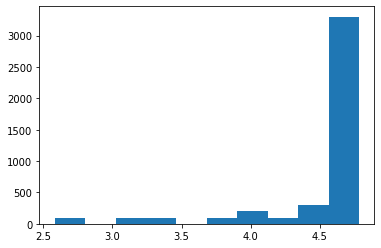

In [183]:
plt.hist(pd.concat(dfs)['G'])

# Value Function Iteration

In [63]:
def create_state_grid():
    Q, K, G, Z, = reversed(list(range(18, 61))), list(range(0,6)), np.linspace(0, 6, num=13), np.linspace(-200, 200, 17)
    return list(product(Q, G, K, Z))
    

In [64]:
create_state_grid()

[(60, 0.0, 0, -200.0),
 (60, 0.0, 0, -175.0),
 (60, 0.0, 0, -150.0),
 (60, 0.0, 0, -125.0),
 (60, 0.0, 0, -100.0),
 (60, 0.0, 0, -75.0),
 (60, 0.0, 0, -50.0),
 (60, 0.0, 0, -25.0),
 (60, 0.0, 0, 0.0),
 (60, 0.0, 0, 25.0),
 (60, 0.0, 0, 50.0),
 (60, 0.0, 0, 75.0),
 (60, 0.0, 0, 100.0),
 (60, 0.0, 0, 125.0),
 (60, 0.0, 0, 150.0),
 (60, 0.0, 0, 175.0),
 (60, 0.0, 0, 200.0),
 (60, 0.0, 1, -200.0),
 (60, 0.0, 1, -175.0),
 (60, 0.0, 1, -150.0),
 (60, 0.0, 1, -125.0),
 (60, 0.0, 1, -100.0),
 (60, 0.0, 1, -75.0),
 (60, 0.0, 1, -50.0),
 (60, 0.0, 1, -25.0),
 (60, 0.0, 1, 0.0),
 (60, 0.0, 1, 25.0),
 (60, 0.0, 1, 50.0),
 (60, 0.0, 1, 75.0),
 (60, 0.0, 1, 100.0),
 (60, 0.0, 1, 125.0),
 (60, 0.0, 1, 150.0),
 (60, 0.0, 1, 175.0),
 (60, 0.0, 1, 200.0),
 (60, 0.0, 2, -200.0),
 (60, 0.0, 2, -175.0),
 (60, 0.0, 2, -150.0),
 (60, 0.0, 2, -125.0),
 (60, 0.0, 2, -100.0),
 (60, 0.0, 2, -75.0),
 (60, 0.0, 2, -50.0),
 (60, 0.0, 2, -25.0),
 (60, 0.0, 2, 0.0),
 (60, 0.0, 2, 25.0),
 (60, 0.0, 2, 50.0),
 (60, 0.0

In [65]:
state_grid = create_state_grid()

In [229]:
st = state_grid[0]

In [235]:
env.reset(st)

In [231]:
env.step(37, (16, 0))

((61, 1.0, 0, -184.0),
 21.752510932727873,
 True,
 'Y: 464401.2061090909, L: 6026, W: 4440.0')

In [55]:
def get_psi_weights(p):
    """p: prob of kid"""
    return (0, 1), (1-p, p)
    
    
def get_eps_weights():
    pass

In [56]:
psi, psi_w = get_psi_weights(0.3)

(0, 1)

In [57]:
def hermgauss_normal(n, sigma):
    """returns np.array of shape (n, 2)
    x in first column, w in second column.
    Easy to iterate over!
    for psi, psi_w in psi:
        <do loop>
    """

    x, w = hermgauss(n)
    
    # needed to normalize weights to 1
    w = w / np.sqrt(np.pi)
    return list(x), list(w)

In [58]:
eps, eps_w = hermgauss_normal(9, 15)

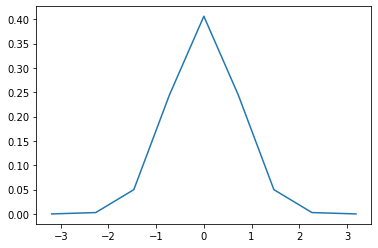

In [59]:
plt.plot(eps, eps_w)

In [60]:
np.array([list(product(psi, eps)) , list(product(psi_w, eps_w))])[:,0]

array([[ 0.0000000e+00, -3.1909932e+00],
       [ 7.0000000e-01,  2.2345844e-05]])

In [61]:
shocks = list(zip((product(psi,eps)), product(psi_w, eps_w)))

E_u = 0.0
rewards, weights = list(), list()
for (psi_i, eps_i), (psi_w_i, eps_w_i) in shocks:

    rewards.append(reward)
    env.reset(state_grid[0])
    _states, reward, done, _info = env.step(37.0, shocks=(eps_i, psi_i))
    w_i = psi_w_i * eps_w_i
    E_u = E_u + w_i * reward
    weights.append(w_i)
    print(E_u)

NameError: name 'state_grid' is not defined

In [327]:
rewards

[22.44565811328782,
 21.752510932727873,
 21.752510932727873,
 21.752510932727873,
 21.752510932727873,
 21.752510932727873,
 21.752510932727873,
 21.752510932727873,
 21.752510932727873,
 21.752510932727873,
 22.44565811328782,
 22.44565811328782,
 22.44565811328782,
 22.44565811328782,
 22.44565811328782,
 22.44565811328782,
 22.44565811328782,
 22.44565811328782]

In [329]:
sum(weights)

1.7724538509055159

In [308]:
env.reset(state_grid[0])

In [292]:
list(product(psi, eps))

[(0, -3.1909932017815277),
 (0, -2.266580584531843),
 (0, -1.468553289216668),
 (0, -0.7235510187528376),
 (0, 0.0),
 (0, 0.7235510187528376),
 (0, 1.468553289216668),
 (0, 2.266580584531843),
 (0, 3.1909932017815277),
 (1, -3.1909932017815277),
 (1, -2.266580584531843),
 (1, -1.468553289216668),
 (1, -0.7235510187528376),
 (1, 0.0),
 (1, 0.7235510187528376),
 (1, 1.468553289216668),
 (1, 2.266580584531843),
 (1, 3.1909932017815277)]

In [334]:
sum(eps_w)

1.7724538509055163

In [369]:
rrr = list()
for e, ew in zip(eps, eps_w):
    rrr.append(e + ew)

In [370]:
sum(rrr)

1.7724538509053183

In [364]:
x, w = hermgauss(10)

In [373]:
np.mean(x)

4.4408920985006264e-17

In [50]:
def calc_expectation(env, state, action, shocks):
    
    E_u = 0.0
    for (psi_i, eps_i), (psi_w_i, eps_w_i) in shocks:
        env.reset(state)
        _states, reward, done, _info = env.step(37.0, (eps_i, psi_i))
        E_u = E_u + psi_w_i * eps_w_i * reward
        
    return E_u

In [400]:
st

(60, 0.0, 0, -200.0)

In [48]:
current_age, max_age = 60, 60

actions = [0, 15, 25, 37, 45]

rewards, states, policy = list(), list(), list()


for state in state_grid:
    if state[0] == max_age:
        
        env.reset(state)

        r_star = - 10000.0
        action_star = 2000
        for action in actions:
            r = calc_expectation(env, state, action, shocks)
            if r > r_star:
                r_star = r
                action_star = action
            
            rewards.append(r_star)
            states.append(state)
            policy.append(action)


NameError: name 'state_grid' is not defined

In [418]:
interps = dict()
for K in range(0, 6):
    
    interps[K]

KeyError: 0

In [423]:
df = pd.DataFrame(states, columns=['Q', 'G', 'K', 'Z'])

In [442]:
res = df[['G', 'Z']].loc[(df['Q'] == 60) & (df['K']==5)]

res_array = np.array(res)
X, Y = np.meshgrid(res_array[:,0],res_array[:,1])


In [440]:
np.array(res)[:,0].shape

(1105,)

In [ ]:
for i in range(50):
    if i % 1000 == 0:
        print(i)
    env.reset(st)
    if not env.Q == current_age:
        # update interpolators
        
        # update current_age
        pass
        
    for i in actions:
        calc_expectation(env, st, 37, shocks)

In [412]:
shocks

[((0, -3.1909932017815277), (0.7, 2.2345844007746576e-05)),
 ((0, -2.266580584531843), (0.7, 0.0027891413212317653)),
 ((0, -1.468553289216668), (0.7, 0.04991640676521791)),
 ((0, -0.7235510187528376), (0.7, 0.2440975028949394)),
 ((0, 0.0), (0.7, 0.4063492063492064)),
 ((0, 0.7235510187528376), (0.7, 0.2440975028949394)),
 ((0, 1.468553289216668), (0.7, 0.04991640676521791)),
 ((0, 2.266580584531843), (0.7, 0.0027891413212317653)),
 ((0, 3.1909932017815277), (0.7, 2.2345844007746576e-05)),
 ((1, -3.1909932017815277), (0.3, 2.2345844007746576e-05)),
 ((1, -2.266580584531843), (0.3, 0.0027891413212317653)),
 ((1, -1.468553289216668), (0.3, 0.04991640676521791)),
 ((1, -0.7235510187528376), (0.3, 0.2440975028949394)),
 ((1, 0.0), (0.3, 0.4063492063492064)),
 ((1, 0.7235510187528376), (0.3, 0.2440975028949394)),
 ((1, 1.468553289216668), (0.3, 0.04991640676521791)),
 ((1, 2.266580584531843), (0.3, 0.0027891413212317653)),
 ((1, 3.1909932017815277), (0.3, 2.2345844007746576e-05))]

In [401]:
calc_expectation(env, st, 37, shocks)

21.96045508689586

In [403]:
_states

(61, 1.0, 1, -196.80900679821846)

In [443]:
x = np.linspace(0, 4, 13)
y = np.array([0, 2, 3, 3.5, 3.75, 3.875, 3.9375, 4])
X, Y = np.meshgrid(x, y)
Z = np.sin(np.pi*X/2) * np.exp(Y/2)

x2 = np.linspace(0, 4, 65)
y2 = np.linspace(0, 4, 65)
f = interp2d(x, y, Z, kind='linear')

In [408]:
{}

array([2.71828183])

In [444]:
X

array([[0.        , 0.33333333, 0.66666667, 1.        , 1.33333333,
        1.66666667, 2.        , 2.33333333, 2.66666667, 3.        ,
        3.33333333, 3.66666667, 4.        ],
       [0.        , 0.33333333, 0.66666667, 1.        , 1.33333333,
        1.66666667, 2.        , 2.33333333, 2.66666667, 3.        ,
        3.33333333, 3.66666667, 4.        ],
       [0.        , 0.33333333, 0.66666667, 1.        , 1.33333333,
        1.66666667, 2.        , 2.33333333, 2.66666667, 3.        ,
        3.33333333, 3.66666667, 4.        ],
       [0.        , 0.33333333, 0.66666667, 1.        , 1.33333333,
        1.66666667, 2.        , 2.33333333, 2.66666667, 3.        ,
        3.33333333, 3.66666667, 4.        ],
       [0.        , 0.33333333, 0.66666667, 1.        , 1.33333333,
        1.66666667, 2.        , 2.33333333, 2.66666667, 3.        ,
        3.33333333, 3.66666667, 4.        ],
       [0.        , 0.33333333, 0.66666667, 1.        , 1.33333333,
        1.66666667, 2.     

In [2]:
from sklearn.ensemble import RandomForestRegressor

In [39]:
def draw_states(Q=60, n=1000):
    G_min, G_max = 0.0, 6.0
    K_min, K_max = 0, 5
    Z_min, Z_max = -200.0, 200.0
    
    Gs = np.random.randint(G_min, G_max, size=n)
    Ks = np.random.uniform(K_min, K_max, size=n)
    Zs = np.random.uniform(Z_min, Z_max, size=n)
    Qs = np.array([Q for _ in range(1000)])
    
    return np.array([Qs, Gs, Ks, Zs]).T

In [40]:
sss = draw_states()

In [41]:
np.random.uniform(0, 200)

166.0792328219118

In [42]:
for i in range(sss.shape[0]):
    sss[0, :]

array([  60.        ,    2.        ,    3.24447039, -100.08024906])

In [43]:
RandomForestRegressor()

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [26]:
env.step()

(Q: 18, G: 2.0, K: 0, Z: 0.0)

In [44]:
env.reset()

In [45]:
sss.shape[0]

1000

In [66]:
max_age=60
rewards, states, policy = list(), list(), list()
shocks = list(zip((product(psi,eps)), product(psi_w, eps_w)))


for i in range(sss.shape[0]):
    state = sss[i, :]
    if state[0] == max_age:
        
        env.reset(state)
        print(state)

        r_star = - 10000.0
        action_star = 2000
        for action in actions:
            r = calc_expectation(env, state, action, shocks)
            if r > r_star:
                r_star = r
                action_star = action
            
            rewards.append(r_star)
            states.append(state)
            policy.append(action)


[  60.            2.            3.24447039 -100.08024906]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices